# Testing convolution

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect
from plotting_functions import plot_weight_matrix, plot_state_variables_vs_time, plot_winning_pattern
from plotting_functions import plot_network_activity, plot_network_activity_angle
from analysis_functions import calculate_recall_time_quantities, calculate_angle_from_history, get_weights
from connectivity_functions import artificial_connectivity_matrix

In [4]:
def create_orthogonal_canonical_representation(minicolumns, hypercolumns):
    aux = []
    for i in range(minicolumns):
        aux.append(i * np.ones(hypercolumns))

    return np.array(aux, dtype='int')

def build_network_representation(matrix, minicolumns, hypercolumns):

    network_representation = np.zeros((len(matrix), minicolumns * hypercolumns), dtype='int')

    for patten, indexes in enumerate(matrix):
        for hypercolumn_index, minicolumn_index in enumerate(indexes):
            index = hypercolumn_index * minicolumns + minicolumn_index
            network_representation[patten, index] = 1
    
    return network_representation

In [5]:
class TimedInput:
    def __init__(self, minicolumns, hypercolumns, network_representation, dt, training_time, inter_pulse_interval=0.0,
                     inter_sequence_interval=0.0, epochs=1):
        
        self.n_units = network_representation.shape[1]
        self.dt = dt
        
        self.network_representation = network_representation
        self.epochs = epochs
        self.training_time = training_time
        self.inter_pulse_interval = inter_pulse_interval
        self.inter_sequence_interval = inter_sequence_interval
        
        self.n_patterns = network_representation.shape[0]
        self.pattern_length = int(training_time / dt)
        self.inter_pulse_interval_length = int(inter_pulse_interval / dt)
        self.inter_sequence_interval_length = int(inter_sequence_interval / dt)

        self.n_time_total = (self.pattern_length + self.inter_pulse_interval_length) * self.n_patterns
        self.n_time_total += self.inter_sequence_interval_length
        self.n_time_total *= epochs
        self.T_total = epochs * ((training_time + inter_pulse_interval) * n_patterns + inter_sequence_interval)
        self.time = np.linspace(0, self.T_total, num=self.n_time_total)

        
        self.S = np.zeros((self.n_units, self.n_time_total))
        self.z_pre = np.zeros_like(self.S)
        self.z_post = np.zeros_like(self.S)
        self.tau_z_pre = None
        self.tau_z_post = None

    def build_timed_input(self):      
        end = 0
        for epoch in range(self.epochs):
            for pattern in range(self.n_patterns):
                start = end
                end = start + self.pattern_length  
                indexes = np.where(self.network_representation[pattern])[0]
                self.S[indexes, start:end] = 1
                end += self.inter_pulse_interval_length
            end += self.inter_sequence_interval_length

        return self.S

    def build_filtered_input_pre(self, tau_z):
        self.tau_z_pre = tau_z
        for index, s in enumerate(self.S.T):
            if index == 0:
                self.z_pre[:, index] = (self.dt / tau_z) * (s - 0)
            else:
                self.z_pre[:, index] = self.z_pre[:, index - 1] + (self.dt / tau_z) * (s - self.z_pre[:, index - 1])

        return self.z_pre

    def build_filtered_input_post(self, tau_z):
        self.tau_z_post = tau_z
        for index, s in enumerate(self.S.T):
            if index == 0:
                self.z_post[:, index] = (self.dt / tau_z) * (s - 0)
            else:
                self.z_post[:, index] = self.z_post[:, index - 1] + (self.dt / tau_z) * (s - self.z_post[:, index - 1])

        return self.z_post
    
    def calculate_probabilities_from_time_signal(self, filtered=False):
        if filtered:
            y_pre = self.z_pre
            y_post = self.z_post
        else:
            y_pre = self.S
            y_post = self.S

        n_units = self.n_units
        n_time_total = self.n_time_total

        p_pre = sp.integrate.simps(y=y_pre, x=self.time, axis=1) / self.T_total
        p_post = sp.integrate.simps(y=y_post, x=self.time, axis=1) / self.T_total
        
        outer_product = np.zeros((n_units, n_units, n_time_total))
        for index, (s_pre, s_post) in enumerate(zip(y_pre.T, y_post.T)):
            outer_product[:, :, index] = s_post[:, np.newaxis] @ s_pre[np.newaxis, :]

        P = sp.integrate.simps(y=outer_product, x=self.time, axis=2) / self.T_total

        return p_pre, p_post, P

## Let's create an input to filter it through convolution

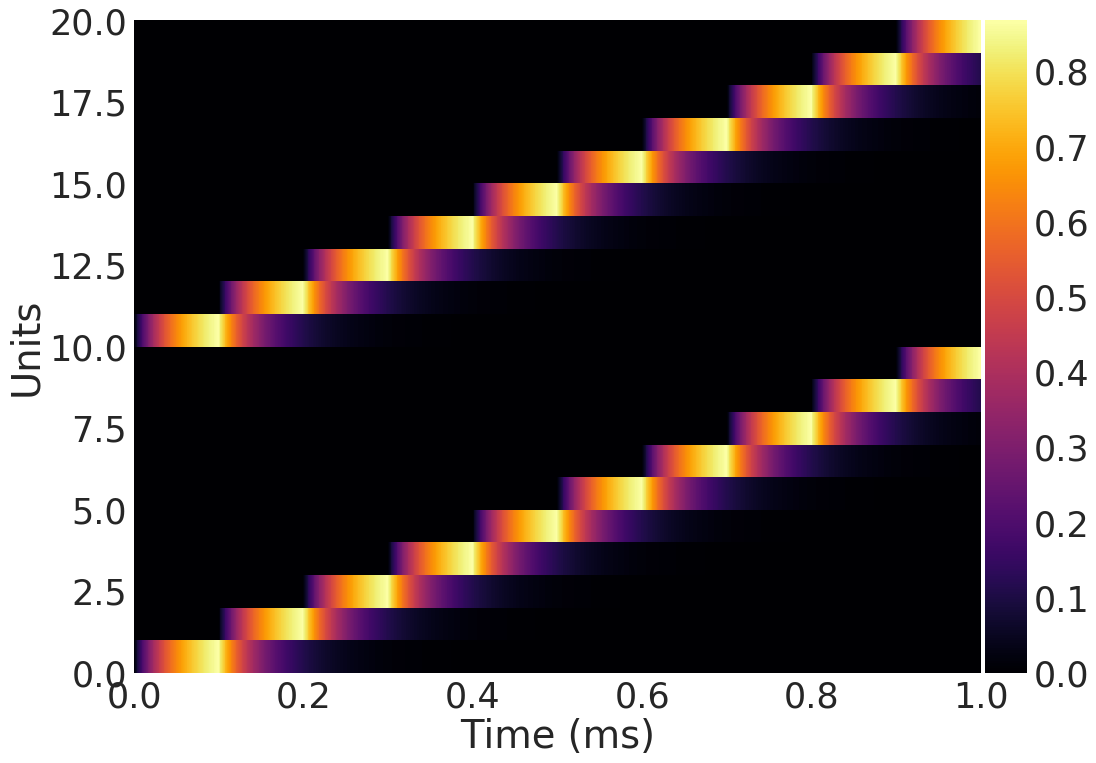

In [54]:
training_time = 0.100
n_patterns = 10
dt = 0.001
minicolumns = 10
hypercolumns = 2

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

timed_input = TimedInput(minicolumns, hypercolumns, network_representation, dt, training_time, inter_pulse_interval=0.0,
                         inter_sequence_interval=0.0, epochs=1)
S = timed_input.build_timed_input()

tau_z_pre = 0.050
tau_z_post = 0.001
z_pre = timed_input.build_filtered_input_pre(tau_z_pre)
z_post = timed_input.build_filtered_input_post(tau_z_post)

figsize = (16, 12)
cmap = matplotlib.cm.inferno

extent = [0, timed_input.T_total, 0, minicolumns * hypercolumns]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
im = ax.imshow(z_pre, cmap=cmap, origin='lower', extent=extent, aspect='auto')
ax.grid(0)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Units')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

In [55]:
signal = timed_input.S[5, :]
time = timed_input.time
e = np.exp(-time / tau_z_pre)

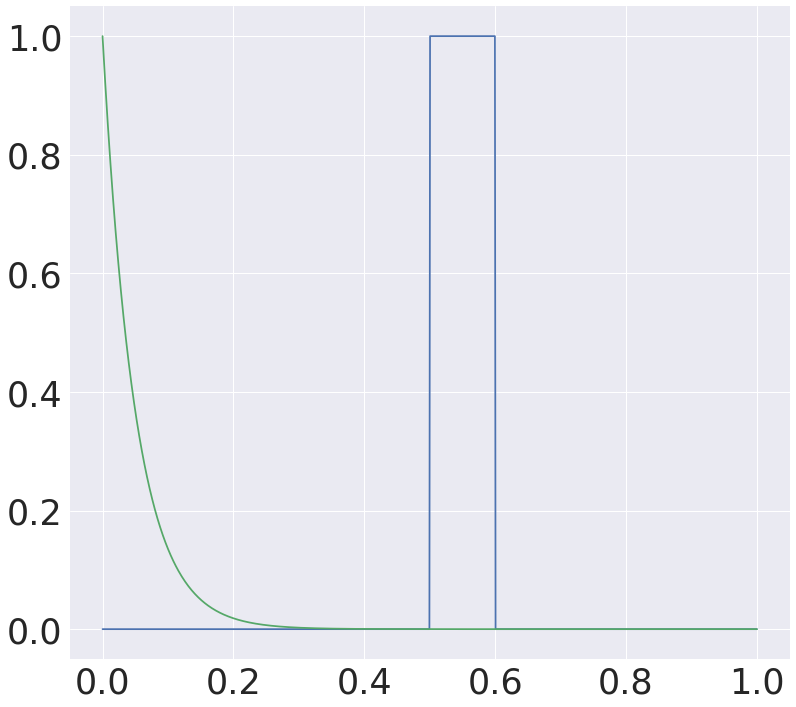

In [56]:
plt.plot(time, signal)
plt.plot(time, e);

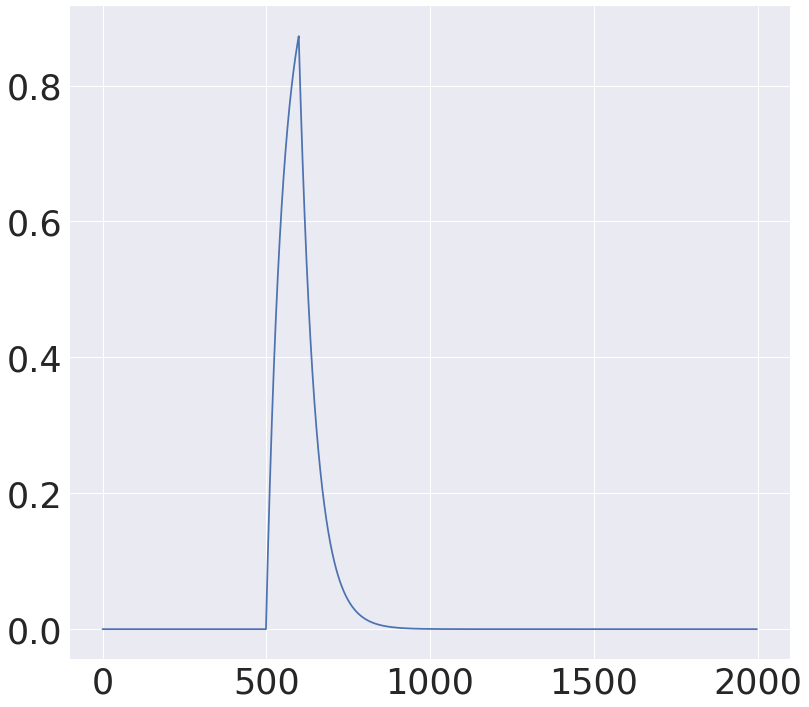

In [60]:
z_filter = sp.convolve(e, signal, mode='full') * (dt / tau_z_pre)
plt.plot(z_filter);

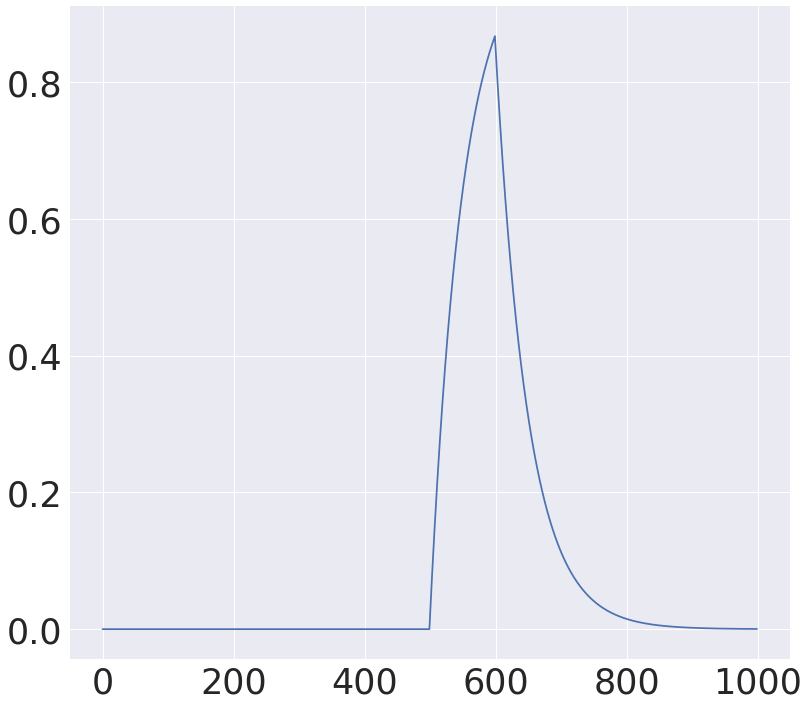

In [61]:
plt.plot(z_pre[5, :])